# Comparison of Tree Height Measurements(LiDAR vs insitu)

This notebook analyzes canopy height data collected with two different methods: in-person onsite (insitu) and aerial LiDAR. The data are merged by site name, and then compared using a regression plot.

Data from two National Ecological Observation (NEON) sites are used for comparison between the methods.
1. [Soaproot Saddle](https://www.neonscience.org/field-sites/soap)
<img src="img/Soaproot_pano.jpg" />


2. [San Joaquin Experimental Range](https://www.neonscience.org/field-sites/sjer)
<img src="img/SJER_pano.jpg" />


### Step 1: Import libraries and set plotting parameters

In [9]:
# import libraries
import os
import pathlib

# import local function directory
import clean

import earthpy as et
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns


# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)


### Step 2: Set data paths

Four paths are needed per site:
* base directory
* insitu csv
* plot location shapefile
* LiDAR Canopy Height Model GeoTIFF

Checks have been added to path_check_1 and path_check_2 ensure all of these paths exist.

In [2]:
# Set home dir
home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar')
# Update directory to home dir
os.chdir(home_dir)


# Set base SJER path
sjer_base_dir = os.path.join(
    home_dir,
    'california',
    'neon-sjer-site')
# Set SJER insitu path
sjer_insitu_path = os.path.join(
    sjer_base_dir,
    '2013',
    'insitu',
    'veg_structure',
    'D17_2013_SJER_vegStr.csv')
# Set SJER plot locations path
sjer_plots_path = os.path.join(
    sjer_base_dir,
    'vector_data',
    'SJER_plot_centroids.shp')
# Set SJER LiDAR Canopy Height Model path
sjer_chm_path = os.path.join(
    sjer_base_dir,
    '2013',
    'lidar',
    'SJER_lidarCHM.tif')
# Check if SJER paths exist
path_check_1 = [sjer_base_dir, sjer_insitu_path, sjer_plots_path, sjer_chm_path]
for path in path_check_1:
    print(os.path.exists(path))
    

# Set SOAP home directory
soap_dir = os.path.join(home_dir,
                       'california',
                       'neon-soap-site')
# Set SOAP insitu path
soap_insitu_path = os.path.join(soap_dir,
                          '2013',
                           'insitu',
                           'veg-structure',
                           'D17_2013_SOAP_vegStr.csv')
# Set SOAP plot locations path
soap_plots_path = os.path.join(soap_dir,
                        'vector_data',
                         'SOAP_centroids.shp')
# Set SOAP LiDAR Canopy Height Model path
soap_chm_path = os.path.join(soap_dir,
                         '2013',
                          'lidar',
                         'SOAP_lidarCHM.tif')
# Check if SOAP paths exist
path_check_2 = [soap_dir, soap_insitu_path, soap_plots_path, soap_chm_path]
for path in path_check_2:
    print(os.path.exists(path))

True
True
True
True
True
True
True
True


### Step 3: Start downloading data from earthpy 

Find original data and activity in the [Earth Data Analytics textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/summarize-and-compare-lidar-insitu-tree-height/).


In [3]:
# Use earthpy to import data
et.data.get_data('spatial-vector-lidar')


'C:\\Users\\Julia\\earth-analytics\\data\\spatial-vector-lidar\\.'

### Step 4: Calculate zonal stats
Use the zstats_meanmax() function and calculate for both NEON sites. View the function in clean.py directory.

In [4]:
# SJER zstats
sjer_zstats = clean.zstats_meanmax(sjer_plots_path, sjer_chm_path)
# SOAP zstats
soap_zstats = clean.zstats_meanmax(soap_plots_path, soap_chm_path)

# Check datasets
soap_zstats.head()

,geometry,OBJECTID,ID,plotType,subtype,plotDimens,Protocols,lidar_max,lidar_mean
0,"POLYGON ((297815.197 4101493.028, 297815.101 4...",1,27,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.250000,20.455827
1,"POLYGON ((297065.197 4100713.028, 297065.101 4...",2,43,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",54.099998,19.804080
2,"POLYGON ((299825.197 4101013.028, 299825.101 4...",3,63,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",32.480000,16.989834
3,"POLYGON ((298175.197 4101433.028, 298175.101 4...",4,91,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.309998,21.980976
4,"POLYGON ((298715.197 4100833.028, 298715.101 4...",5,95,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",33.869999,17.412048


### Step 5:  Get stats for insitu data
Use the insitu_meanmax() function and calculate for both NEON sites. View the function in clean.py directory.

In [5]:
# SJER site insitu data
sjer_insitu = clean.insitu_meanmax(sjer_insitu_path, 'plotid')
# SOAP site insitu data
soap_insitu = clean.insitu_meanmax(soap_insitu_path, 'plotid')

# Check datasets
sjer_insitu.head(), soap_insitu.head()

(          insitu_max  insitu_mean
 plotid                           
 SJER1068        19.3     3.866667
 SJER112         23.9     8.221429
 SJER116         16.0     8.218750
 SJER117         11.0     6.512500
 SJER120          8.8     7.600000,
           insitu_max  insitu_mean
 plotid                           
 SOAP1343         6.5     2.112500
 SOAP139        120.0     4.745902
 SOAP143         19.7     2.530702
 SOAP1515         3.4     1.776923
 SOAP1563         1.9     1.071429)

### Step 6: Merge datasets
Use the merge_df() function and calculate for both NEON sites. View the function in clean.py directory.

In [6]:
# Adjust SOAP site ID's before merging
if not soap_zstats['ID'].str.contains('SOAP').any():
    soap_zstats['ID'] = ('SOAP' + soap_zstats['ID'])
    
# Merge data for SOAP site
soap_merge_df = clean.merge_df(soap_zstats, soap_insitu, id_col='ID')

# Merge data for SJER site
sjer_merge_df = clean.merge_df(sjer_zstats, sjer_insitu, id_col='Plot_ID')

sjer_merge_df.head(), soap_merge_df.head()

(                                            geometry   Plot_ID   Point  \
 0  POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
 1  POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
 2  POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   
 3  POLYGON ((256196.947 4108752.026, 256196.851 4...   SJER117  center   
 4  POLYGON ((255988.372 4110476.079, 255988.276 4...   SJER120  center   
 
       northing     easting plot_type  lidar_max  lidar_mean  insitu_max  \
 0  4111567.818  255852.376     trees  19.049999   11.544347        19.3   
 1  4111298.971  257406.967     trees  24.019999   10.369277        23.9   
 2  4110819.876  256838.760     grass  16.070000    7.518398        16.0   
 3  4108752.026  256176.947     trees  11.059999    7.675346        11.0   
 4  4110476.079  255968.372     grass   5.740000    4.591177         8.8   
 
    insitu_mean  
 0     3.866667  
 1     8.221429  
 2     8.218750  
 3     6.512500  


### Step 7: Plot the data

The regression plots in seaborn are primarily intended to add a visual guide that helps to emphasize patterns in a dataset during exploratory data analyses. Regression plots as the name suggests creates a regression line between 2 parameters and helps to visualize their linear relationships ([source: geeksforgeeks.org](https://www.geeksforgeeks.org/seaborn-regression-plots/)).

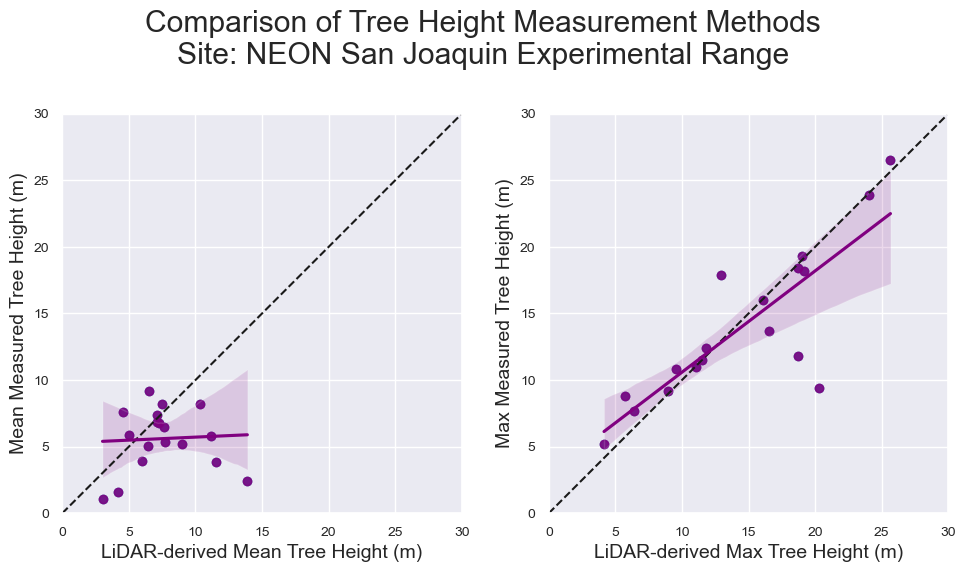

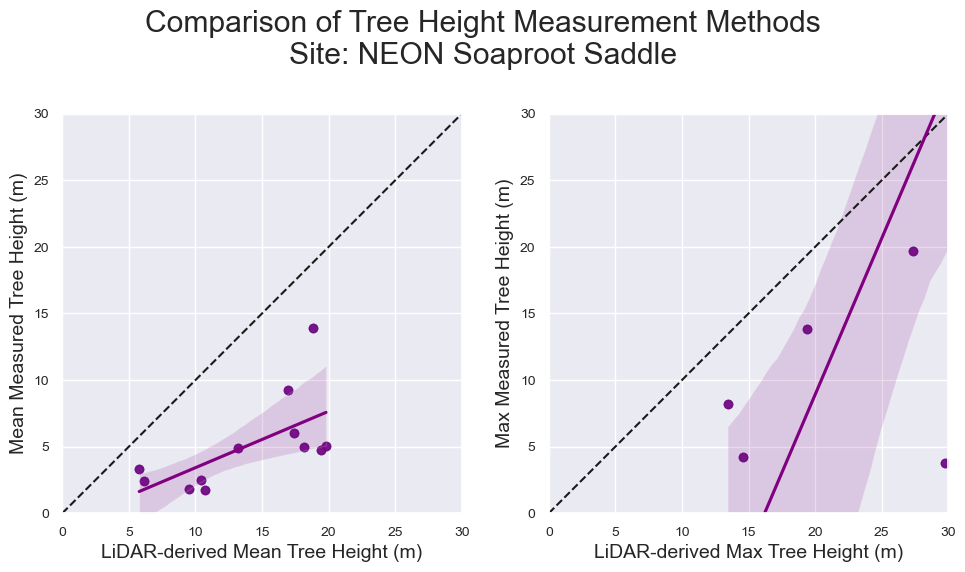

(None, None)

In [7]:
# Run plotting function over NEON sites
sjer_plot = clean.plot_mergedf('San Joaquin Experimental Range', sjer_merge_df)
soap_plot = clean.plot_mergedf('Soaproot Saddle', soap_merge_df)

sjer_plot, soap_plot

### Alternate option: use the class saved in clean.py
Use this class to obtain the zonal stats, insitu aggregation, and merged dataframes found in the steps above.

In [8]:
# Use data loader class on SJER site
neon_dl = clean.NEONDataLoader('SJER', 'Plot_ID', {'separator':'_', 'plot':'_plot'})

sjer_merge_class = neon_dl.merge_df()